# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [4]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [5]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [6]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(73, 6)


,title,price,year,link,brand,age
0,2007 silverado 3500 classic lt3 diesel dually,25000,2007.0,https://charlottesville.craigslist.org/cto/d/e...,missing,18.0
1,2014 jeep wrangler sport,12500,2014.0,https://charlottesville.craigslist.org/cto/d/k...,jeep,11.0
2,"2017 ford fiesta titanium, 43,000 miles.",10495,2017.0,https://charlottesville.craigslist.org/cto/d/o...,ford,8.0
3,work van,2600,NaN,https://charlottesville.craigslist.org/cto/d/p...,missing,NaN
4,2002 ford ranger (look),4800,2002.0,https://charlottesville.craigslist.org/cto/d/c...,ford,23.0


With the data in and wrangled, we can now do some analysis:

count       73.000000
mean     11639.013699
std      13784.384301
min       1000.000000
25%       3500.000000
50%       5900.000000
75%      14230.000000
max      79999.000000
Name: price, dtype: float64


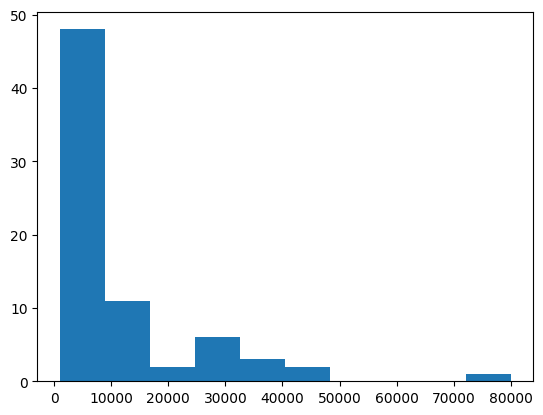

count    64.00000
mean     16.40625
std      10.69597
min       2.00000
25%      11.00000
50%      14.50000
75%      19.00000
max      62.00000
Name: age, dtype: float64


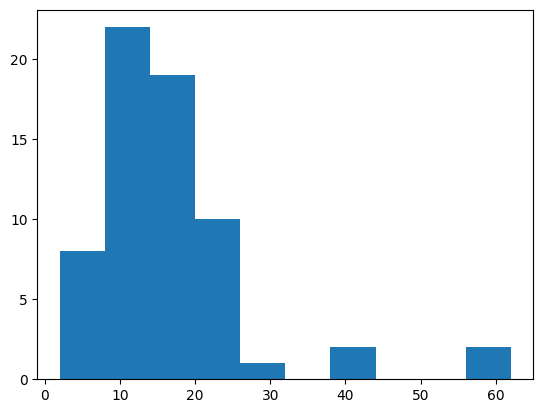

In [7]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

In [ ]:
from bs4 import BeautifulSoup
import requests, pandas as pd, numpy as np, re

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}

# Category: msa (musical instruments); purveyor=owner filters to owner-listed items
url = 'https://charlottesville.craigslist.org/search/msa?purveyor=owner#search=2~gallery~0'

# Download the search results page
raw = requests.get(url, headers=header)
raw.raise_for_status()

# Parse HTML with BeautifulSoup
page = BeautifulSoup(raw.text, 'html.parser')

# Each search card lives in an <li class="cl-static-search-result"> 
listings = page.find_all('li', class_="cl-static-search-result")
print(f"Found {len(listings)} listings")

data = []  # will collect one dict per listing
for li in listings:
    # Pull key elements from each card
    title_el = li.find('div', class_='title')
    price_el = li.find('div', class_='price')
    link_el  = li.find('a', href=True)
    loc_el   = li.find('div', class_='location')
    time_el  = li.find('time')

    # Lowercase title for easier downstream text operations
    title = title_el.get_text(strip=True).lower() if title_el else np.nan

    # Strip non-digits and cast to float for price, else NaN
    price_txt = price_el.get_text(strip=True) if price_el else None
    price = float(re.sub(r'[^\d.]','',price_txt)) if price_txt else np.nan

    # Absolute URL to the post
    link = link_el['href'] if link_el else np.nan

    # Neighborhood string shown on the card
    location = loc_el.get_text(strip=True) if loc_el else np.nan

    # Post timestamp and convert to pandas datetime if available
    posted_at = pd.to_datetime(time_el['datetime']) if time_el and time_el.has_attr('datetime') else pd.NaT

    # Append a normalized record for this listing
    data.append({
        'title': title,
        'price': price,
        'link': link,
        'location': location,
        'posted_at': posted_at
    })

# Build a DataFrame from collected records
df = pd.DataFrame(data)
print(f"Collected {len(df)} listings")
df.head()


Found 142 listings
Collected 142 listings


,title,price,link,location,posted_at
0,rockbridge guitar deposit for build-place in line,1260.0,https://charlottesville.craigslist.org/msg/d/c...,JPA Cville 22903,NaT
1,"professional musician offering guitar, songwri...",100.0,https://charlottesville.craigslist.org/msg/d/r...,NaN,NaT
2,gibson usa les paul and es335 promotional banner,40.0,https://charlottesville.craigslist.org/msg/d/c...,Charlottesville,NaT
3,usa peavey t-tube mini-bandit 65w 1x12 guitar amp,250.0,https://charlottesville.craigslist.org/msg/d/g...,N Richmond I-295 Exit 43C,NaT
4,vintage yamaha japan 1x12 combo amp euc,250.0,https://charlottesville.craigslist.org/msg/d/g...,Richmond I-295 Exit 43C,NaT


Fetches Charlottesville Craigslist musical instruments (owner only) from the results page, then parses the HTML with BeautifulSoup, and extracts key fields from each result card. After sending a request with a desktop-like User-Agent, it finds all items and pulls the title, price text, the post link, the displayed location, and the posted time. Missing pieces become NaN/NaT. Each listing is stored as a dict in data, which is then turned into a pandas DataFrame df. FInally, the script prints how many listings it found and shows the first few rows.

Summary stats for price:
count       142.000000
mean       1366.633803
std       10351.911241
min           0.000000
25%         100.000000
50%         237.500000
75%         483.750000
max      123456.000000
Name: price, dtype: float64


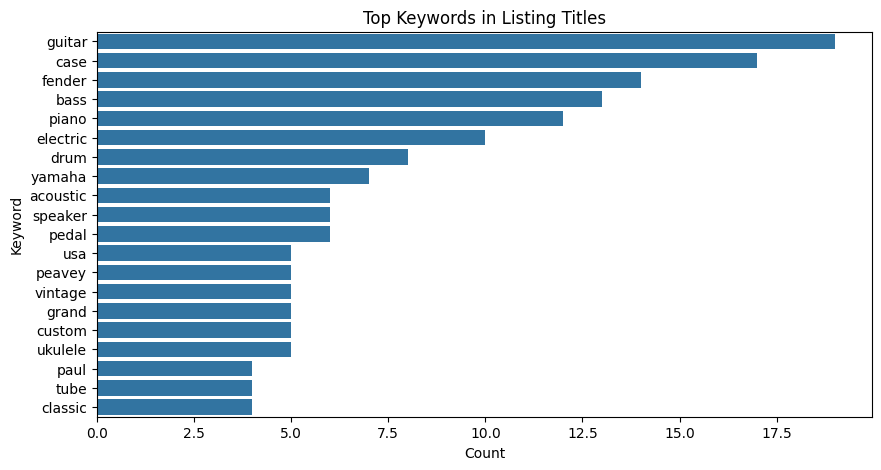

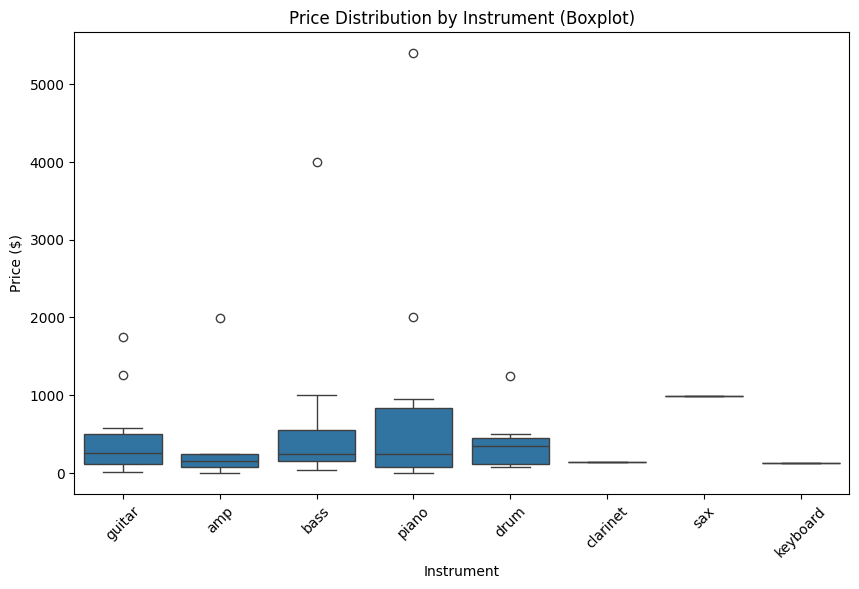

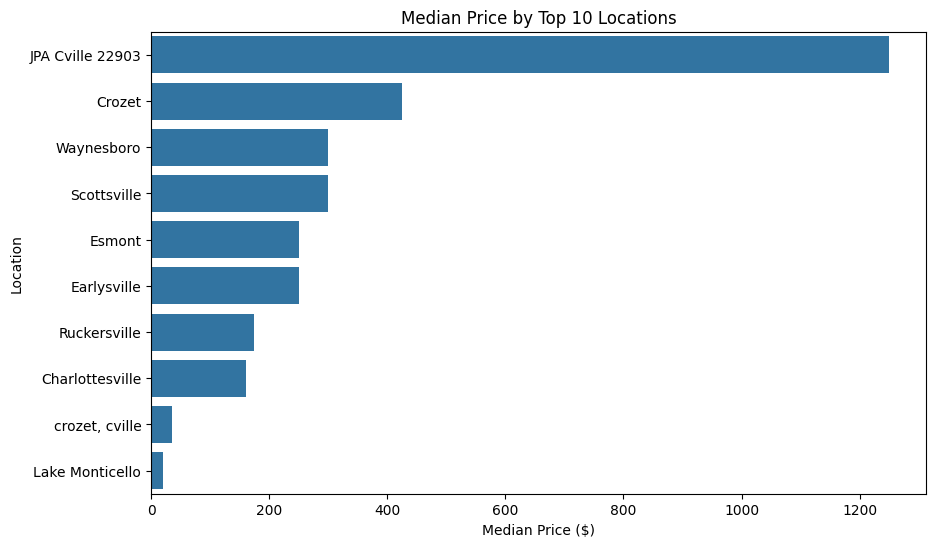

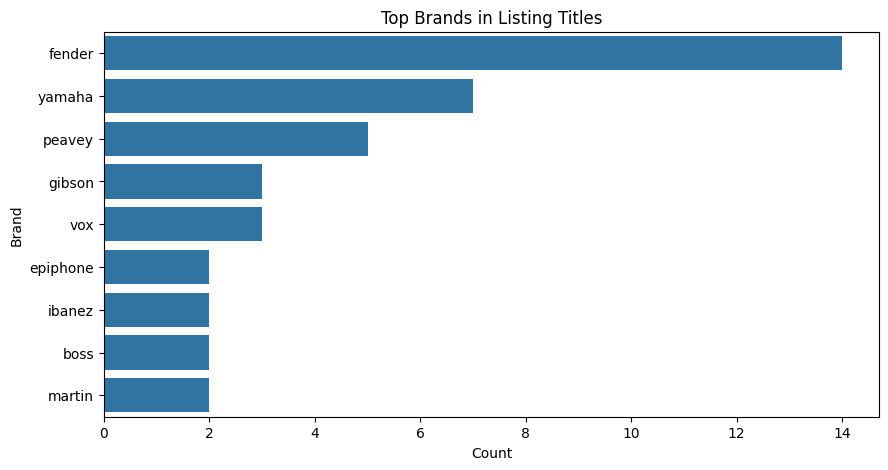

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Summary stats
print("Summary stats for price:")
print(df['price'].describe())

# Top keywords in titles
def tokenize(text):
    if not isinstance(text, str):
        return []
    return re.findall(r"[a-zA-Z0-9]+", text.lower())

stopwords = {"the","and","for","amp","with","from","this","that","set","new","old","used","good","great"}
all_tokens = [t for title in df['title'] for t in tokenize(title) if t not in stopwords and len(t) > 2]

word_freq = Counter(all_tokens).most_common(20)
keywords_df = pd.DataFrame(word_freq, columns=["keyword","count"])

plt.figure(figsize=(10,5))
sns.barplot(x="count", y="keyword", data=keywords_df)
plt.title("Top Keywords in Listing Titles")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.show()

# Price by instrument (boxplot)
instrument_keywords = ["guitar","drum","amp","piano","keyboard","violin","bass","trumpet","sax","clarinet"]
instrument_rows = []

df["instrument"] = "other"
for kw in instrument_keywords:
    mask = df['title'].str.contains(kw, case=False, na=False)
    df.loc[mask, "instrument"] = kw

plt.figure(figsize=(10,6))
sns.boxplot(x="instrument", y="price", data=df[df["instrument"]!="other"])
plt.title("Price Distribution by Instrument (Boxplot)")
plt.xlabel("Instrument")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.show()

# Price by location (barplot of median prices for top 10 locations)
if "location" in df.columns and df["location"].notna().any():
    top_locs = df["location"].value_counts().head(10).index
    loc_stats = df[df["location"].isin(top_locs)].groupby("location")["price"].median().sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=loc_stats.values, y=loc_stats.index)
    plt.title("Median Price by Top 10 Locations")
    plt.xlabel("Median Price ($)")
    plt.ylabel("Location")
    plt.show()

# Top brands
brands = [
    "fender","gibson","yamaha","roland","korg","martin","taylor","peavey",
    "ibanez","epiphone","boss","akai","akai","shure","electro","vox","kawai"
]
brand_counts = Counter()

for title in df["title"]:
    tokens = tokenize(title)
    for b in brands:
        if b in tokens:
            brand_counts[b] += 1

brand_df = pd.DataFrame(brand_counts.most_common(10), columns=["brand","count"])

plt.figure(figsize=(10,5))
sns.barplot(x="count", y="brand", data=brand_df)
plt.title("Top Brands in Listing Titles")
plt.xlabel("Count")
plt.ylabel("Brand")
plt.show()


First, summary stats gives you a quick look at the overall price distribution. It shows that there is a very large spread with the median being 237.50, but the standard deviation being 10351.911241. Also, the max of 123456.00 shows that there are major outliers in the data. Next, the Top Keywords in Listing Titles horizontal bar chart shows which tokens appear most often in titles, highlighting common gear or descriptors. It shows that guitars, cases, and fenders dominate the listings. The Price Distribution by Instrument (Boxplot) compares prices across instrument keywords. The boxplot shows that most instruments cluster under $1,000, with guitars, amps, drums, and basses generally staying in the few-hundred-dollar range. Pianos show a wider spread and some higher-value listings. We can also see a few outliers into the thousands, which could suggest premium or professional-grade instruments. The Median Price by Top 10 Locations chart compares typical prices (medians) across the most frequent locations. The chart shows that median instrument prices vary widely by location, with JPA Cville 22903 standing out as a much higher priced area. Finally, the Top Brands in Listing Titles bar chart ranks how often brand names appear. This chart shows that Fender dominates Craigslist listings, appearing nearly twice as often as the next most common brand, Yamaha.